<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="figures/k2_pix_small.png">
*This notebook contains an excerpt instructional material from [gully](https://twitter.com/gully_) and the [K2 Guest Observer Office](https://keplerscience.arc.nasa.gov/); the content is available [on GitHub](https://github.com/gully/k2-metadata).*


<!--NAVIGATION-->
< [K2 target index fun](01.04-TPF-header-scrape.ipynb) | [Contents](Index.ipynb) | [K2 target index fun](02.02-TPF-header_analysis.ipynb) >

# K2 Guest Observer Proposal Information

Things to say:
- we generated this combined csv file from notebook_01.01
- What questions can this file *alone* answer?

In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
GO_df = pd.read_csv('../metadata/tidy/GO_proposal_metadata.csv', 
                    dtype={'campaign':str})

In [4]:
GO_df.head()

,EPIC ID,RA (J2000) [deg],Dec (J2000) [deg],magnitude,Investigation IDs,campaign
0,200000811,,,,LC_M35_TILE,0
1,200000812,,,,LC_M35_TILE,0
2,200000813,,,,LC_M35_TILE,0
3,200000814,,,,LC_M35_TILE,0
4,200000815,,,,LC_M35_TILE,0


### Group campaigns 9a and 9b together

In [5]:
GO_df.campaign.unique()

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9a', '9b', '10', '11',
       '12', '13', '14', '15'], dtype=object)

In [6]:
GO_df['main_campaign'] = GO_df.campaign.copy()

In [7]:
GO_df = GO_df.set_value(GO_df.campaign.isin(['9a','9b']), 'main_campaign', 9)

In [8]:
GO_df['main_campaign'] = GO_df['main_campaign'].astype(int)

In [9]:
GO_df.main_campaign.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

### Multiple visits

In [10]:
GO_df.shape

(426130, 7)

There are 426,130 K2 targets.  Some targets are not unique, since some campaigns have revisited the same region in the sky.

In [11]:
GO_df.nunique()['EPIC ID']

421729

Let's count up how many times each object has been observed.

In [12]:
visits = GO_df.groupby('EPIC ID').main_campaign.nunique()

In [13]:
visits.groupby(visits).count()

main_campaign
1    420583
2      1146
Name: main_campaign, dtype: int64

So the vast majority of targets have been observed only once, which makes sense.  
About 1146 targets have been observed twice in the main campaigns.
Recall that campaign 9 was divided into sub-campaigns, 9a and 9b, which have substantial but not identical overlap.

In [14]:
multi_visit = pd.merge(visits[visits >1].to_frame().rename(columns={'main_campaign':'visits'}),
                       GO_df, left_index=True, right_on='EPIC ID')

In [15]:
multi_visit.main_campaign.unique()

array([ 1, 10,  2, 11, 15,  4, 13,  9])

In [16]:
multi_visit.shape

(2332, 8)

Indeed, most of the multi-visit count stems from where campaign 9 and 11 fields overlap.

### Campaign-level analysis: Target proposed for by multiple guest observers

In [17]:
import numpy as np

This takes ~ 7 seconds:

In [18]:
GO_df['GO_clean'] = GO_df['Investigation IDs'].str.strip(' ').str.split('|')

In [19]:
%time GO_ids_with_dups = GO_df['GO_clean'].aggregate(np.concatenate)

CPU times: user 5.38 s, sys: 94 ms, total: 5.48 s
Wall time: 5.48 s


In [20]:
GO_ids = np.unique(GO_ids_with_dups)

In [21]:
len(GO_ids)

1712

In [22]:
gb = GO_df.groupby('main_campaign')

In [23]:
def robust_concat(in_group):
    all_vals = np.concatenate(in_group.values)
    length = len(np.unique(all_vals))
    return length

In [24]:
GO_ids_by_campaign = gb.GO_clean.apply(lambda x: np.concatenate(x.values)).apply(np.unique)

In [25]:
GO_ids_by_campaign.apply(len)

main_campaign
0      98
1      77
2      95
3      80
4     101
5     105
6     144
7      83
8      84
9      40
10     96
11    154
12    135
13    125
14    144
15    153
Name: GO_clean, dtype: int64

In [26]:
GO_ids_by_campaign.apply(lambda x: np.sum([y.startswith('GO') for y in x]))

main_campaign
0      97
1      77
2      93
3      80
4     101
5     104
6      79
7      78
8      69
9      38
10     79
11     88
12    101
13    110
14     93
15    101
Name: GO_clean, dtype: int64

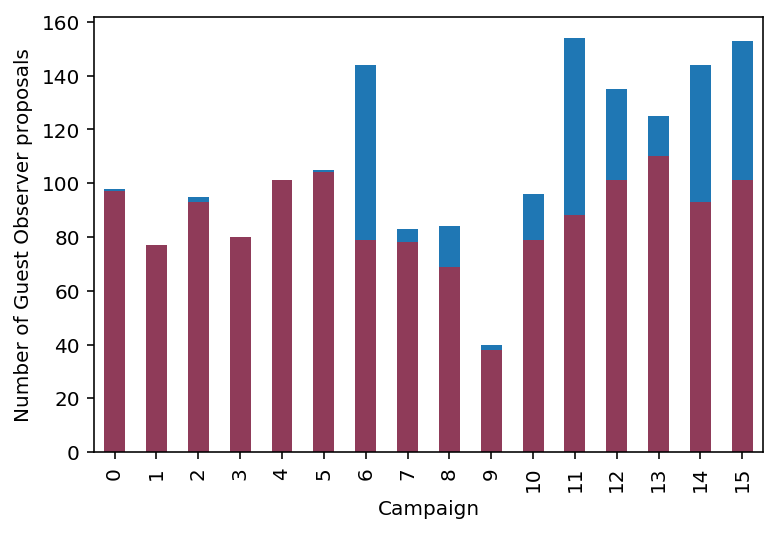

In [27]:
GO_ids_by_campaign.apply(len).plot('bar')
GO_ids_by_campaign.apply(lambda x: np.sum([y.startswith('GO') for y in x])).plot('bar', color='r', alpha=0.5)
plt.ylabel('Number of Guest Observer proposals')
plt.xlabel('Campaign');

The blue include non-GO proposals-- superstamps and the like.

In [28]:
proposal_counts_by_epic = GO_df.groupby('EPIC ID').GO_clean.agg(robust_concat)

In [29]:
GO_df['n_proposals'] = GO_df.GO_clean.apply(len)

In [30]:
raw_popularity = GO_df.groupby('n_proposals').nunique()['EPIC ID'].reset_index().rename(columns={'EPIC ID':'Count'})

Make a histogram of popularity.

In [31]:
corrected_popularity = proposal_counts_by_epic.groupby(
    proposal_counts_by_epic).count().rename('counts').to_frame().reset_index().rename(columns={'GO_clean':'n_proposals'})

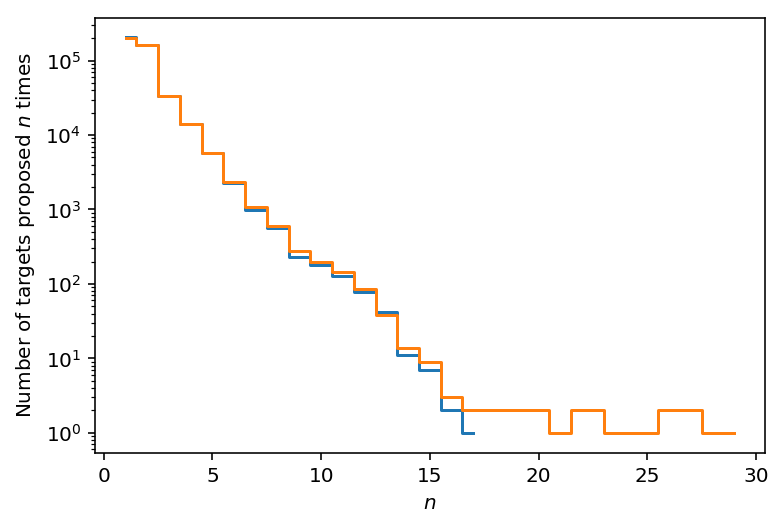

In [32]:
plt.step(raw_popularity.n_proposals, raw_popularity.Count, where='mid')
plt.step(corrected_popularity.n_proposals, corrected_popularity.counts, where='mid')
plt.yscale('log')
plt.ylabel('Number of targets proposed $n$ times')
plt.xlabel('$n$');

What are the targets for which we received >15 unique proposals??  These are the "most popular targets".

In [33]:
most_popular = proposal_counts_by_epic[proposal_counts_by_epic > 17]

In [34]:
most_popular = most_popular.to_frame().rename(columns={'GO_clean':'combined_proposals'})

In [35]:
comb = pd.merge(most_popular, GO_df, left_index=True, right_on='EPIC ID')

In [37]:
comb.sort_values('combined_proposals', ascending=False)[['combined_proposals', 'EPIC ID', 'main_campaign', 'n_proposals']]

,combined_proposals,EPIC ID,main_campaign,n_proposals
70059,29,210651981,4,15
330815,29,210651981,13,14
70469,26,210675409,4,13
330905,26,210675409,13,13
71146,26,210709514,4,13
331069,26,210709514,13,13
71863,25,210741091,4,13
331186,25,210741091,13,12
70321,24,210667985,4,13
330878,24,210667985,13,11


### Number of targets by GO proposal.

In [38]:
GO_id_df = pd.DataFrame({'GO_id':GO_ids_with_dups})

In [39]:
GO_id_df['val']=1

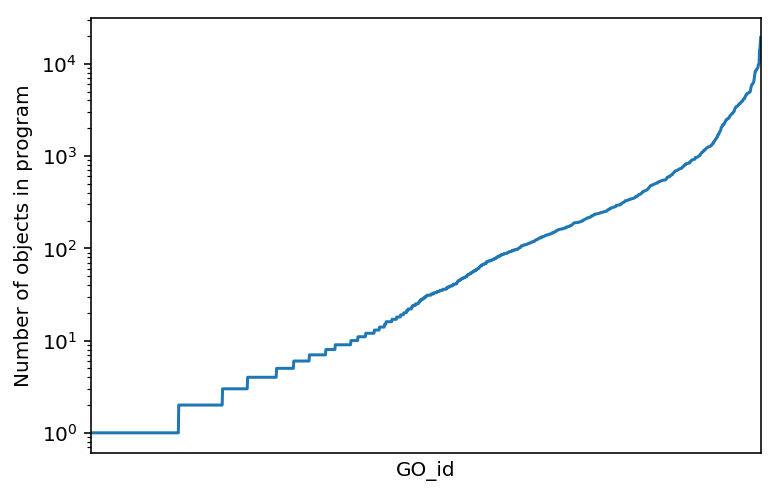

In [40]:
GO_id_df.groupby('GO_id').val.count().sort_values().plot()
plt.yscale('log')
plt.xticks([])
plt.ylabel('Number of objects in program')

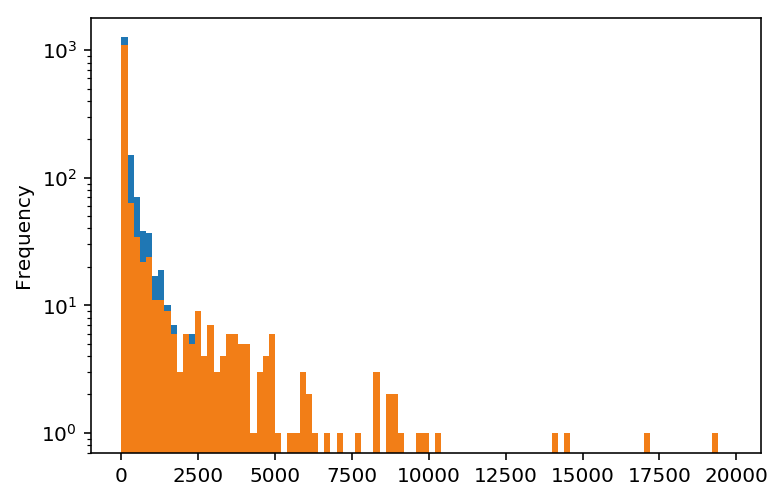

In [41]:
GO_id_df.groupby('GO_id').val.count().sort_values().plot('hist', bins=np.arange(0, 20000, 200))
GO_id_df[GO_id_df.GO_id.str.startswith('GO')].groupby('GO_id').val.count().sort_values().plot('hist', alpha=0.95,
                                                                                              bins=np.arange(0, 20000, 200))
plt.yscale('log')

<!--NAVIGATION-->
< [K2 target index fun](01.04-TPF-header-scrape.ipynb) | [Contents](Index.ipynb) | [K2 target index fun](02.02-TPF-header_analysis.ipynb) >